In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from interest_rates import *
import os
from tqdm import tqdm

In [14]:
df = pd.read_csv('data/final_ratings.csv')
print(df.shape)
df.head(2)

(100000, 2)


,id,rate
0,100001,0.070655
1,100002,0.158496


In [15]:
df2 = pd.read_csv('data/break_even_rate.csv')
print(df2.shape)
df2.head(2)

(100000, 2)


,id,break_even_rate
0,100001,0.036959
1,100002,0.116814


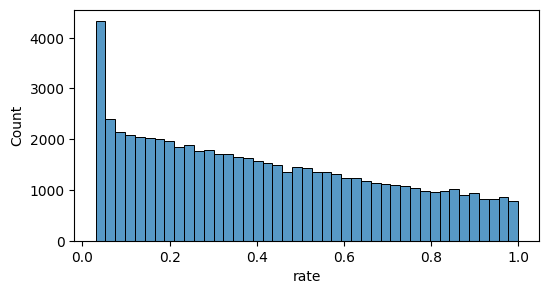

In [16]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.histplot(df.rate)
plt.show()

In [6]:
sum(df.rate.isna())*100/df.shape[0]

0.097

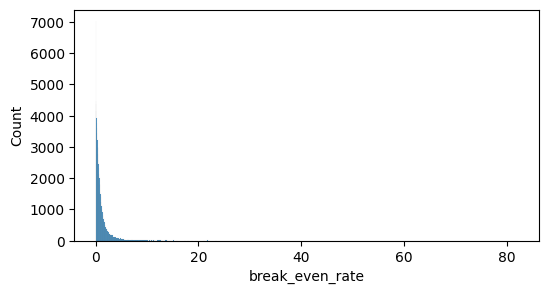

In [17]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.histplot(df2.break_even_rate)
plt.show()

In [2]:
dirname = os.path.dirname
root = os.getcwd()

data_path = os.path.join(dirname(root), "data")
path = os.path.join(data_path,"PastLoans.csv")
path_new_set = os.path.join(data_path, "NewApplications_3_Round1.csv")
path_proba = os.path.join(root + '/data', 'default_predictions.csv') #the dataset with the probabilities of default
path_proba = os.path.join(root + '/data', 'default_predictions_backtesting_mix_models.csv') #the dataset with the probabilities of default
columns_test = ["competing1","competing2","rate"]

In [6]:
range_a = np.linspace(1, 1.3, 10)
range_b = np.linspace(0.01, 0.04, 10)
best_param = (0, 0)
profit = -np.Inf
market_share = 0
for a in tqdm(range_a):
    for b in range_b:
        probas = pd.read_csv(path_proba)["Proba Default"]
        df_new_preds = pd.read_csv(path_new_set, index_col="id")
        index_ids = df_new_preds.index
        df_preds = compute_interest_rates(probas, a, b, index_ids)
        df_past_results = pd.read_csv(os.path.join(data_path,"profit_31.csv"))
        df_back_test = df_past_results.merge(df_preds, on='id', how="inner")
        df_back_test["winner"] = df_back_test[columns_test].min(axis=1)
        df_clients_won = df_back_test[df_back_test["winner"]==df_back_test["rate"]]

        new_profit = df_clients_won['profit'].sum()
        new_market_share = df_clients_won.shape[0]*100/df_new_preds.shape[0]
        #print(new_profit, new_market_share, a, b)
        if new_profit > profit:
            best_param = (a, b)
            market_share = new_market_share
            profit = new_profit

print(f"Profits made with this strategy during backtesting : {profit}")
print(f"Market share : {market_share}%")
print(f"Best rate formula : {a}*break-even-rate + {b}")

100%|██████████| 10/10 [00:54<00:00,  5.44s/it]

Profits made with this strategy during backtesting : -146561.85660000003
Market share : 0.103%
Best rate formula : 1.2*break-even-rate + 0.03


## Optimizing the rating strategy

In [7]:
import optuna

def objective(trial):
    a = trial.suggest_float('a', 1, 2)
    b = trial.suggest_float('b', 0.01, 0.2)
    probas = pd.read_csv(path_proba)
    df_new_preds = pd.read_csv(path_new_set, index_col="id")
    index_ids = df_new_preds.index
    df_preds = compute_interest_rates(probas, a, b, index_ids)
    trial.set_user_attr("number_propositions", sum(~df_preds.rate.isna()))

    df_past_results = pd.read_csv(os.path.join(data_path,"profit_31.csv"))
    df_back_test = df_past_results.merge(df_preds, on='id', how="inner")
    df_back_test["winner"] = df_back_test[columns_test].min(axis=1)
    df_clients_won = df_back_test[df_back_test["winner"]==df_back_test["rate"]]
    trial.set_user_attr("number_clients", df_clients_won.shape[0]) 

    market_share = df_clients_won.shape[0]*100/df_new_preds.shape[0]
    trial.set_user_attr("market_share", market_share) 

    profit = df_clients_won['profit'].sum()
    return profit

study = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"Best profit : {study.best_value}")
print(f"Number of rates offered : {study.best_trial.user_attrs.get('number_propositions')}")
print(f"Number of clients won : {study.best_trial.user_attrs.get('number_clients')}")
print(f"Market share : {study.best_trial.user_attrs.get('market_share')}%")
print(f"Best rate formula : {np.round(study.best_params.get('a'), 3)}*break-even-rate + {np.round(study.best_params.get('b'), 3)}")

100%|██████████| 100/100 [00:39<00:00,  2.51it/s]

Best profit : 4801.2629
Number of rates offered : 24444
Number of clients won : 7
Market share : 0.007%
Best rate formula : 1.483*break-even-rate + 0.193
